In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, GlobalAvgPool2D, ReLU, MaxPooling2D, AveragePooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pywt 
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2025-04-10 20:32:29.293864: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:01<00:00, 165.81it/s]


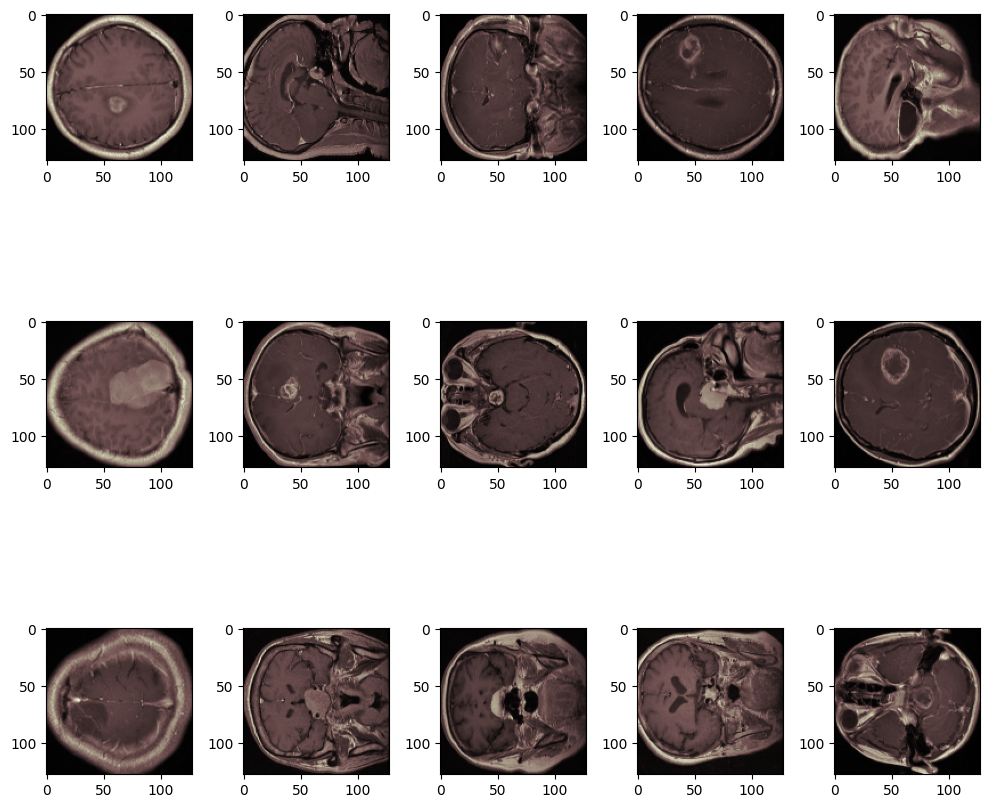

(614, 128, 128, 3)
(2450, 128, 128, 3)
(614, 3)
(2450, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/cropped'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
class WaveletPoolingTF(Layer):
    """
    Pure TensorFlow implementation of Wavelet Pooling using Haar-like filters
    """
    def __init__(self, **kwargs):
        super(WaveletPoolingTF, self).__init__(**kwargs)
        
        # Define Haar wavelet filters
        self.LL_filter = tf.constant([[0.5, 0.5], [0.5, 0.5]], dtype=tf.float32)
        self.LH_filter = tf.constant([[0.5, 0.5], [-0.5, -0.5]], dtype=tf.float32)
        self.HL_filter = tf.constant([[0.5, -0.5], [0.5, -0.5]], dtype=tf.float32)
        self.HH_filter = tf.constant([[0.5, -0.5], [-0.5, 0.5]], dtype=tf.float32)
        
    def build(self, input_shape):
        self.channels = input_shape[-1]
        super(WaveletPoolingTF, self).build(input_shape)
        
    def call(self, inputs):
        # Reshape filters for convolution
        LL = tf.reshape(self.LL_filter, [2, 2, 1, 1])
        LH = tf.reshape(self.LH_filter, [2, 2, 1, 1])
        HL = tf.reshape(self.HL_filter, [2, 2, 1, 1])
        HH = tf.reshape(self.HH_filter, [2, 2, 1, 1])
        
        # Output tensors initialization
        outputs = []
        
        # Apply wavelet decomposition on each channel
        for c in range(self.channels):
            # Extract single channel and add dimension for convolution
            x_c = inputs[:, :, :, c:c+1]
            
            # Apply wavelet filters with stride 2 for downsampling
            LL_c = tf.nn.conv2d(x_c, LL, strides=[1, 2, 2, 1], padding='SAME')
            LH_c = tf.nn.conv2d(x_c, LH, strides=[1, 2, 2, 1], padding='SAME')
            HL_c = tf.nn.conv2d(x_c, HL, strides=[1, 2, 2, 1], padding='SAME')
            HH_c = tf.nn.conv2d(x_c, HH, strides=[1, 2, 2, 1], padding='SAME')
            
            # Concatenate the four subbands for this channel
            channel_output = tf.concat([LL_c, LH_c, HL_c, HH_c], axis=-1)
            outputs.append(channel_output)
        
        # Concatenate all channels' outputs
        output = tf.concat(outputs, axis=-1)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, input_shape[3] * 4)


def wavelet_pooling(inputs):
    """
    Apply wavelet pooling to the input tensor
    
    Args:
        inputs: The input tensor
    
    Returns:
        The wavelet pooled tensor
    """
    c = inputs.shape[3]
    x = WaveletPoolingTF()(inputs)
    x = Conv2D(c, 1, padding='same')(x)
    return x

def SEA_block(inputs, channel=512, reduction=4):
    
    b, h, w, c = inputs.shape.as_list()

    SE_out = tf.keras.layers.AveragePooling2D(pool_size=(w, h))(inputs)
    SE_out = tf.reshape(SE_out, [-1,c])
    
    SE_out = tf.keras.Sequential([
            Dense(units=c // reduction, use_bias=False),
            ReLU(),
            Dense(units=c, use_bias=False),
            Activation('sigmoid')
        ])(SE_out)
    
    SE_out = tf.reshape(SE_out, [-1,1,1,c])
    SEA_out = tf.multiply(inputs, SE_out)
    
    return SEA_out


def RCB(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Conv2D(c, 3, padding='same')(inputs)
    x = Activation('sigmoid')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, 3, padding='same')(inputs)
    x = Activation('sigmoid')(x)
    x = Add()([x, Conv2D(16, 1, padding='same')(inputs)])
    x = BatchNormalization()(x)

    return x


def MCF(inputs):

    c = inputs.shape[3]*2
    a_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(inputs)
    a_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(a_tensor)
    a_tensor = Conv2D(c, 3, padding='same', dilation_rate=(2, 2))(a_tensor)
    a_tensor = Conv2D(c, 3, padding='same', dilation_rate=(4, 4))(a_tensor)
    a_tensor = SEA_block(a_tensor)
    a_tensor = Add()([a_tensor, Conv2D(c, 1, padding='same')(inputs)])
    a_tensor = Activation('sigmoid')(a_tensor)

    b_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(inputs)
    b_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(b_tensor)
    b_tensor = Conv2D(c, 3, padding='same', dilation_rate=(2, 2))(b_tensor)
    b_tensor = SEA_block(b_tensor)
    b_tensor = Add()([b_tensor, Conv2D(c, 1, padding='same')(inputs)])
    b_tensor = Activation('sigmoid')(b_tensor)

    c_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(inputs)
    c_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(c_tensor)
    c_tensor = SEA_block(c_tensor)
    c_tensor = Add()([c_tensor, Conv2D(c, 1, padding='same')(inputs)])
    c_tensor = Activation('sigmoid')(c_tensor)

    d_tensor = Conv2D(c, 3, padding='same', dilation_rate=(1, 1))(inputs)
    d_tensor = SEA_block(d_tensor)
    d_tensor = Add()([d_tensor, Conv2D(c, 1, padding='same')(inputs)])
    d_tensor = Activation('sigmoid')(d_tensor)

    x = Add()([a_tensor, b_tensor, c_tensor, d_tensor])

    return x

def MAC(inputs, t):
    c = inputs.shape[3]
    a_tensor = MaxPooling2D(pool_size=(pow(2, t), pow(2, t)))(inputs)
    b_tensor = AveragePooling2D(pool_size=(pow(2, t), pow(2, t)))(inputs)
    c_tensor = Conv2D(c, 3, strides=pow(2, t), padding='same')(inputs)
    x = Concatenate()([a_tensor, b_tensor, c_tensor])
    x = BatchNormalization()(x)
    x = Conv2D(c, 1, padding='same')(x)
    x = Conv2D(c*pow(2, t-1), 1, padding='same')(x)
    return x


def dense_block_1(inputs):

    channel = inputs.shape[3]
    a_tensor = MCF(inputs)
    b_tensor = MaxPooling2D()(a_tensor)
    b_tensor = MCF(b_tensor)
    c_tensor = MaxPooling2D()(b_tensor)
    c_tensor = MCF(c_tensor)
    d_tensor = MaxPooling2D()(c_tensor)
    d_tensor = MCF(d_tensor)
    e_tensor = MaxPooling2D()(d_tensor)
    a_tensor = MAC(a_tensor, 4)
    b_tensor = MAC(b_tensor, 3)
    c_tensor = MAC(c_tensor, 2)
    d_tensor = MAC(d_tensor, 1)
    x = Add()([a_tensor, b_tensor, c_tensor, d_tensor, e_tensor])

    return x



def dense_block_2(inputs):

    channel = inputs.shape[3]
    a_tensor = MCF(inputs)
    b_tensor = wavelet_pooling(a_tensor)
    b_tensor = MCF(b_tensor)
    c_tensor = wavelet_pooling(b_tensor)
    c_tensor = MCF(c_tensor)
    d_tensor = wavelet_pooling(c_tensor)
    d_tensor = MCF(d_tensor)
    e_tensor = wavelet_pooling(d_tensor)
    a_tensor = MAC(a_tensor, 4)
    b_tensor = MAC(b_tensor, 3)
    c_tensor = MAC(c_tensor, 2)
    d_tensor = MAC(d_tensor, 1)
    x = Add()([a_tensor, b_tensor, c_tensor, d_tensor, e_tensor])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))

    x = RCB(inputs)
    
    a_tensor = dense_block_2(x)
    b_tensor = dense_block_2(x)
    c_tensor = dense_block_1(x)

    x = Add()([a_tensor, b_tensor, c_tensor])
    x = Conv2D(a_tensor.shape[3], 3, padding='same')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-04-10 18:04:40.295158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 18:04:40.484261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 128, 128, 16  0           ['conv2d_1[0][0]']               
                                )                                                             

In [6]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-WMCFNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/25
264/264 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.7434
Epoch 1: val_accuracy improved from -inf to 0.53890, saving model to model-WMCFNet.h5
Epoch 1: 172.62 seconds
264/264 [==============================] - 173s 641ms/step - loss: 0.6861 - accuracy: 0.7434 - val_loss: 1.3664 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 2/25
264/264 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7735
Epoch 2: val_accuracy improved from 0.53890 to 0.67647, saving model to model-WMCFNet.h5
Epoch 2: 168.86 seconds
264/264 [==============================] - 169s 639ms/step - loss: 0.5800 - accuracy: 0.7735 - val_loss: 0.8849 - val_accuracy: 0.6765 - lr: 1.0000e-04
Epoch 3/25
264/264 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7694
Epoch 3: val_accuracy did not improve from 0.67647
Epoch 3: 166.66 seconds
264/264 [==============================] - 167s 631ms/step - loss: 0.5871 - accuracy: 0.7694 - val_loss: 2.072

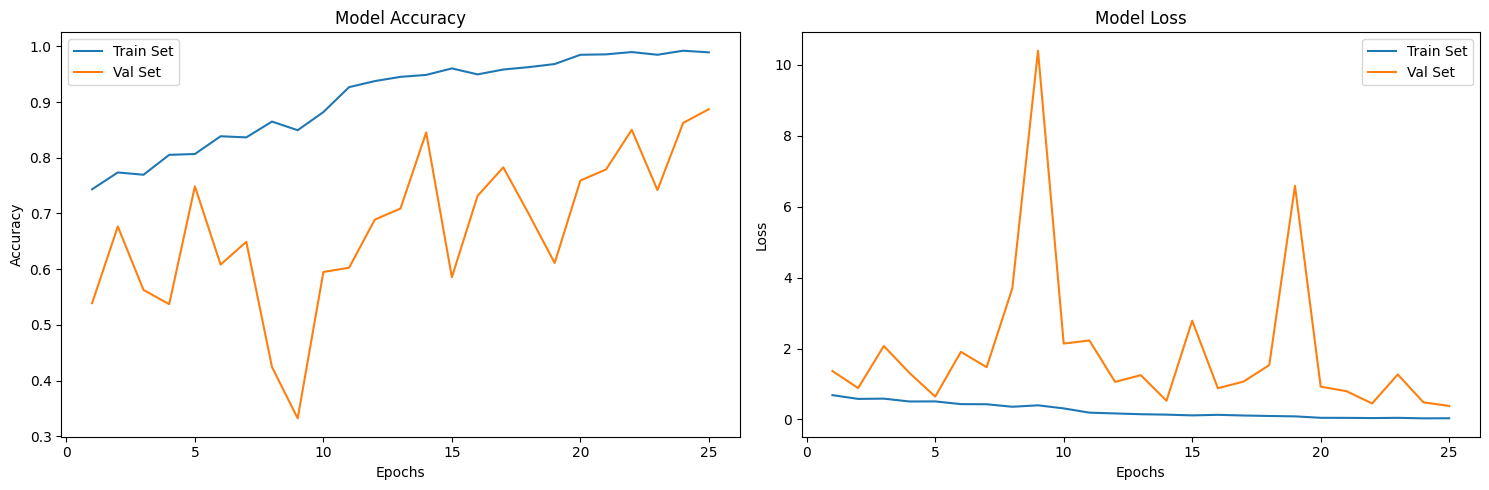

20/20 [==============================] - 4s 175ms/step - loss: 0.3233 - accuracy: 0.9023
Test Accuracy:  90.23
              precision    recall  f1-score   support

      glioma     0.9100    0.9545    0.9317       286
  meningioma     0.8085    0.8028    0.8057       142
   pituitary     0.9653    0.8978    0.9304       186

    accuracy                         0.9023       614
   macro avg     0.8946    0.8851    0.8893       614
weighted avg     0.9033    0.9023    0.9022       614



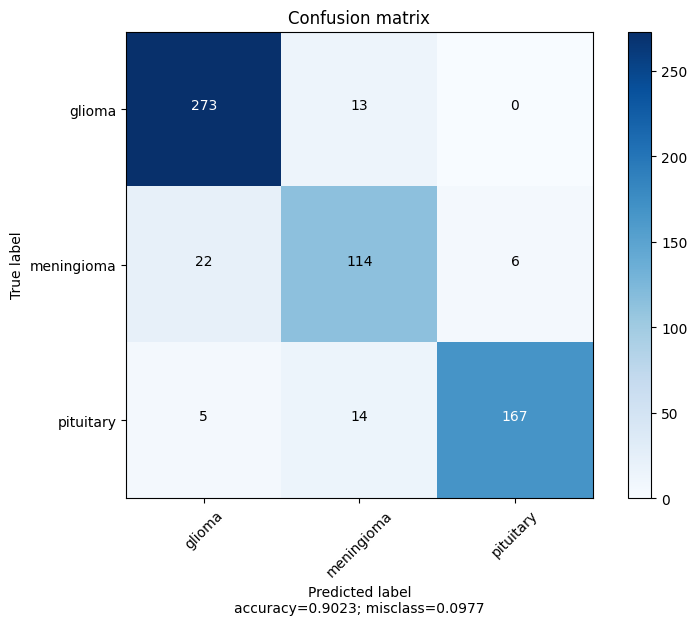

In [7]:
draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

2025-04-10 20:35:00.591564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 20:35:00.752208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:38:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 128, 128, 16  0           ['conv2d_1[0][0]']               
                                )                                                             

2025-04-10 20:36:38.133856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2025-04-10 20:36:38.649070: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


62/62 [==============================] - ETA: 0s - loss: 3.7221 - accuracy: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.32653, saving model to model-WMCFNet.h5
Epoch 1: 149.04 seconds
62/62 [==============================] - 149s 904ms/step - loss: 3.7221 - accuracy: 0.4889 - val_loss: 22.8425 - val_accuracy: 0.3265 - lr: 1.0000e-04
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.3869 - accuracy: 0.5918
Epoch 2: val_accuracy did not improve from 0.32653
Epoch 2: 38.98 seconds
62/62 [==============================] - 39s 629ms/step - loss: 1.3869 - accuracy: 0.5918 - val_loss: 14.9052 - val_accuracy: 0.3265 - lr: 1.0000e-04
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.6268
Epoch 3: val_accuracy did not improve from 0.32653
Epoch 3: 38.61 seconds
62/62 [==============================] - 39s 624ms/step - loss: 1.0275 - accuracy: 0.6268 - val_loss: 8.5689 - val_accuracy: 0.3265 - lr: 1.0000e-04
Epoch 4/50
62/62 [===

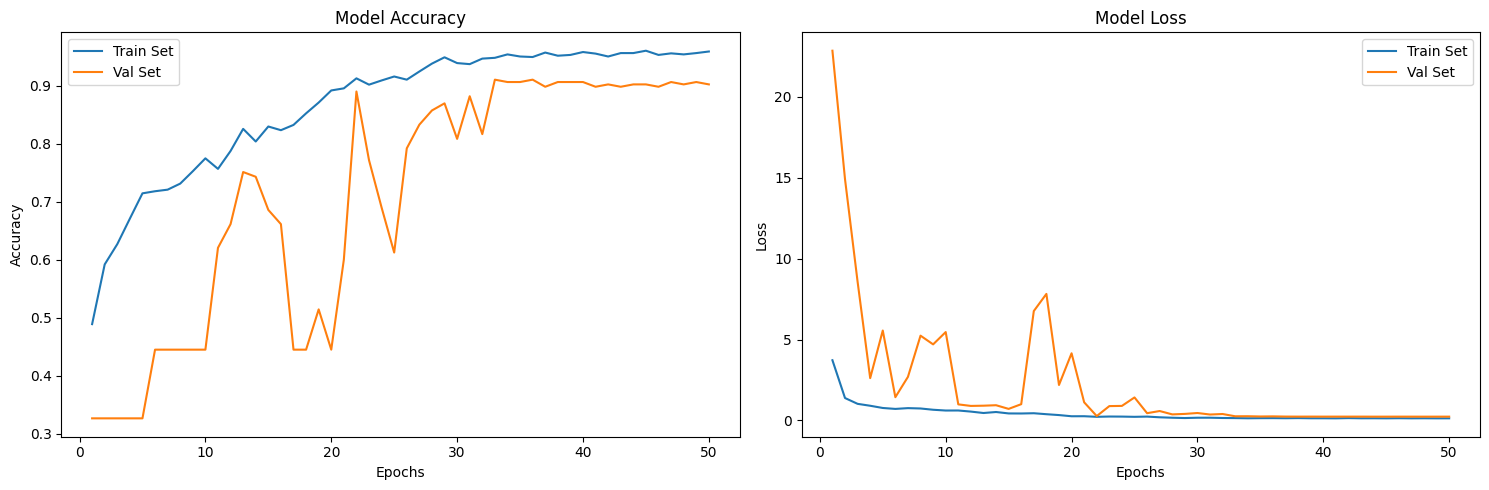

20/20 [==============================] - 3s 168ms/step - loss: 0.2272 - accuracy: 0.9121
Test Accuracy:  91.21
              precision    recall  f1-score   support

      glioma     0.9184    0.9441    0.9310       286
  meningioma     0.8467    0.8169    0.8315       142
   pituitary     0.9508    0.9355    0.9431       186

    accuracy                         0.9121       614
   macro avg     0.9053    0.8988    0.9019       614
weighted avg     0.9116    0.9121    0.9117       614



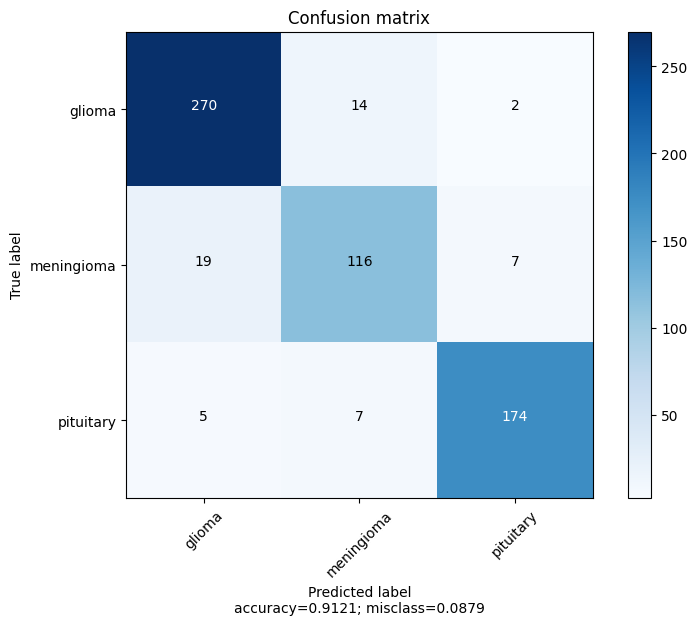

In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-WMCFNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 128, 128, 16  0           ['conv2d_1[0][0]']               
                                )                                                             

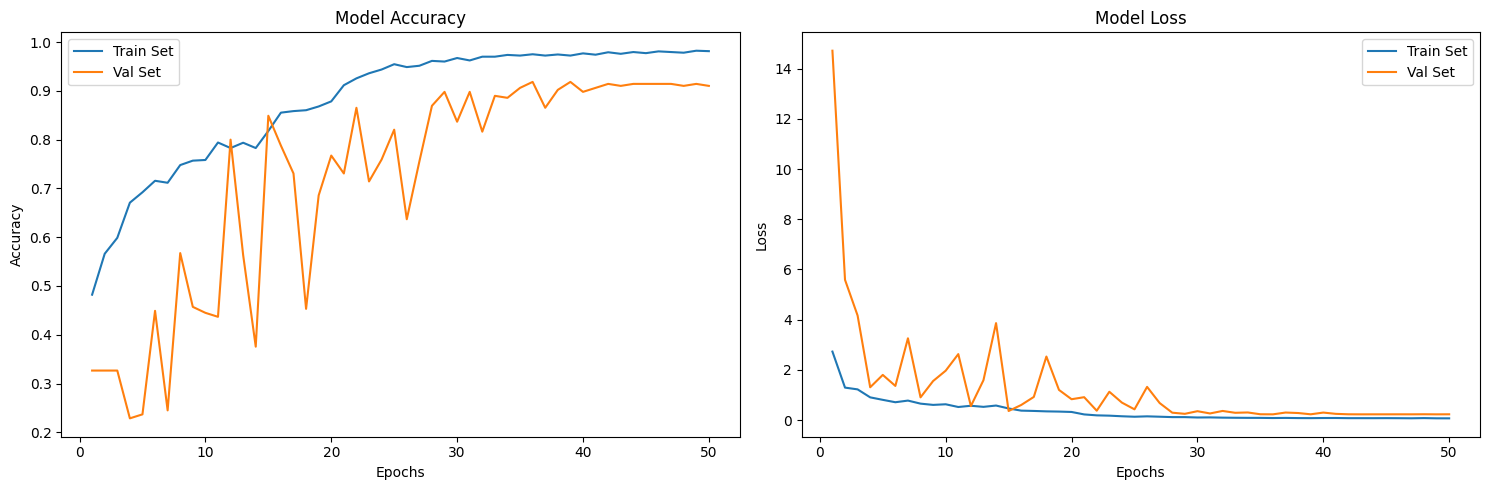

20/20 [==============================] - 4s 185ms/step - loss: 0.2246 - accuracy: 0.9104
Test Accuracy:  91.04
              precision    recall  f1-score   support

      glioma     0.9100    0.9545    0.9317       286
  meningioma     0.8605    0.7817    0.8192       142
   pituitary     0.9459    0.9409    0.9434       186

    accuracy                         0.9104       614
   macro avg     0.9055    0.8924    0.8981       614
weighted avg     0.9094    0.9104    0.9092       614



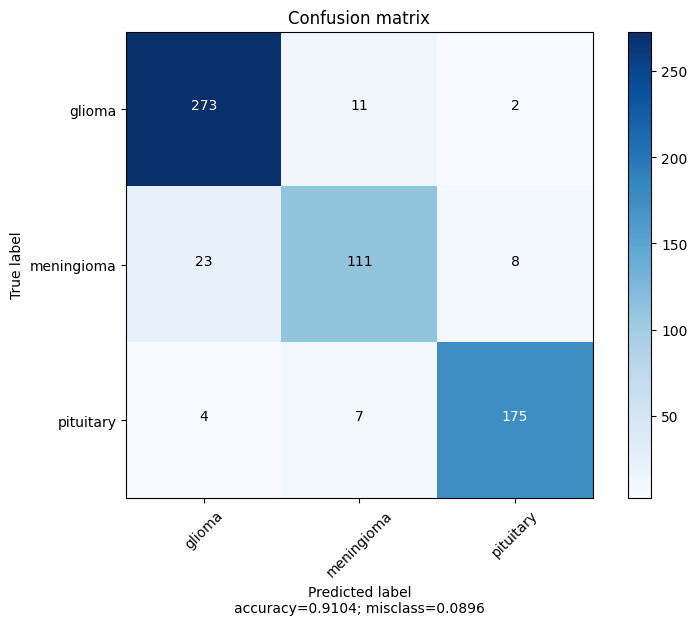

In [5]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-WMCFNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 128, 128, 16  0           ['conv2d_1[0][0]']               
                                )                                                             

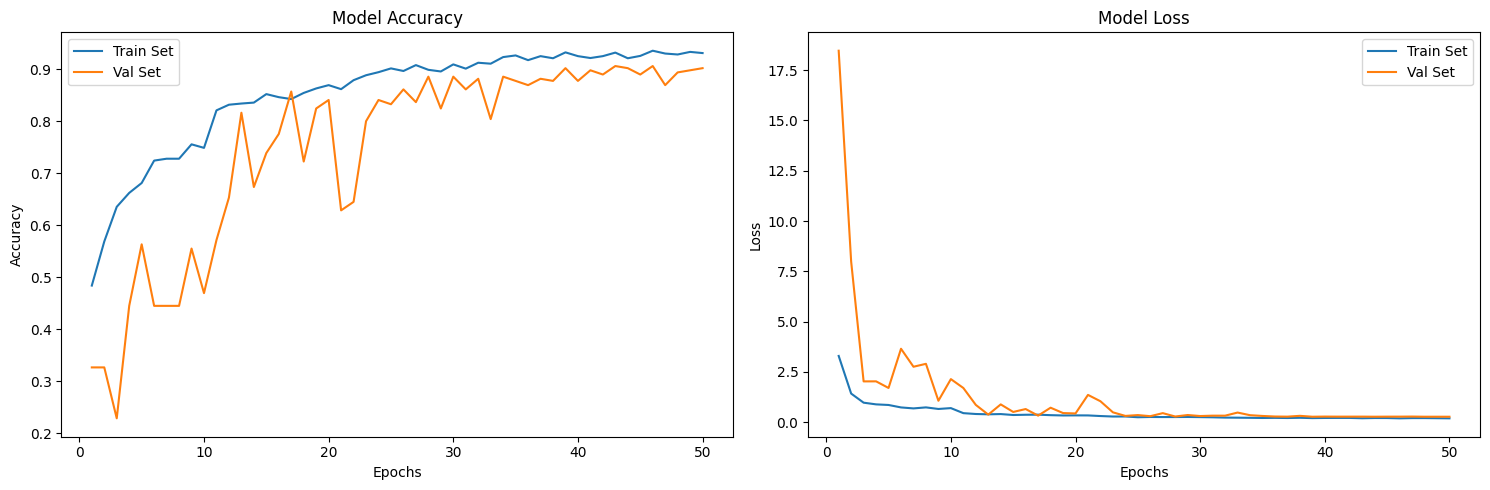

20/20 [==============================] - 4s 183ms/step - loss: 0.2754 - accuracy: 0.8990
Test Accuracy:  89.9
              precision    recall  f1-score   support

      glioma     0.9085    0.9371    0.9225       286
  meningioma     0.8227    0.8169    0.8198       142
   pituitary     0.9438    0.9032    0.9231       186

    accuracy                         0.8990       614
   macro avg     0.8917    0.8857    0.8885       614
weighted avg     0.8993    0.8990    0.8989       614



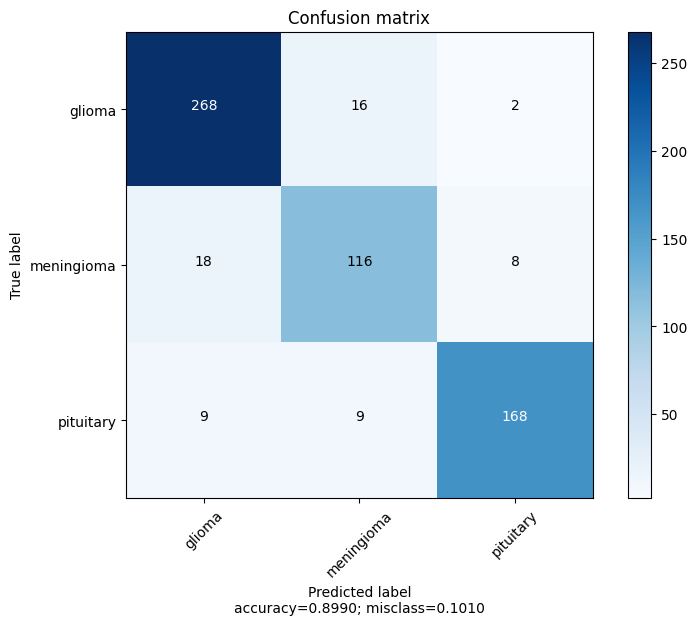

In [6]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-WMCFNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 128, 128, 16  0           ['conv2d_1[0][0]']               
                                )                                                             

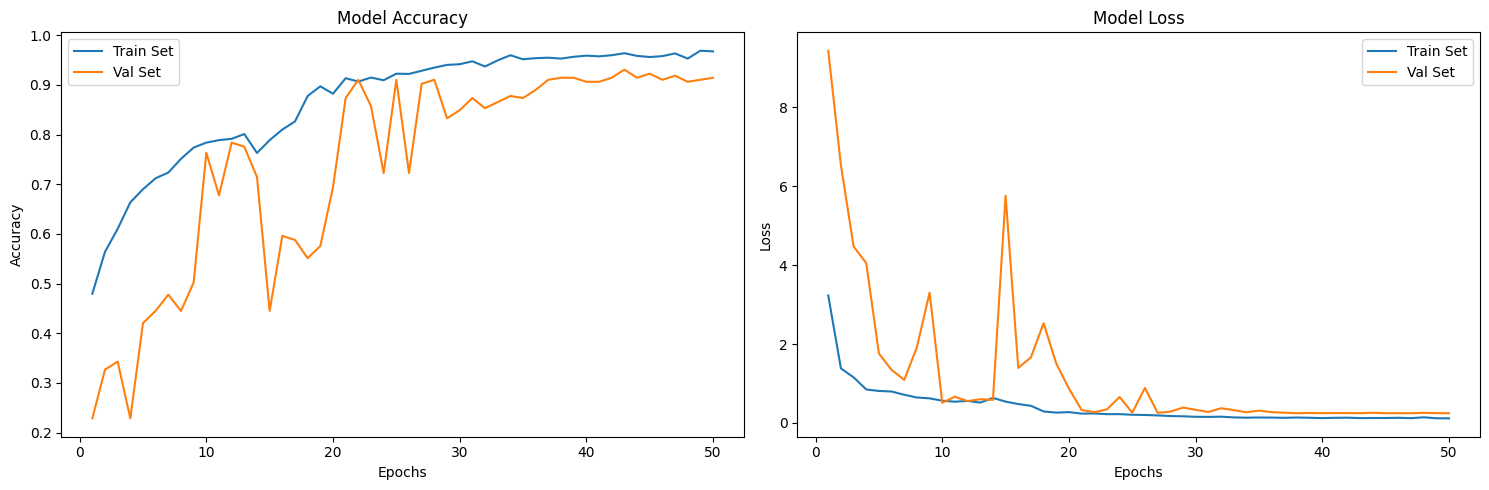

20/20 [==============================] - 4s 177ms/step - loss: 0.2260 - accuracy: 0.9072
Test Accuracy:  90.72
              precision    recall  f1-score   support

      glioma     0.9184    0.9441    0.9310       286
  meningioma     0.8309    0.7958    0.8129       142
   pituitary     0.9457    0.9355    0.9405       186

    accuracy                         0.9072       614
   macro avg     0.8983    0.8918    0.8948       614
weighted avg     0.9064    0.9072    0.9066       614



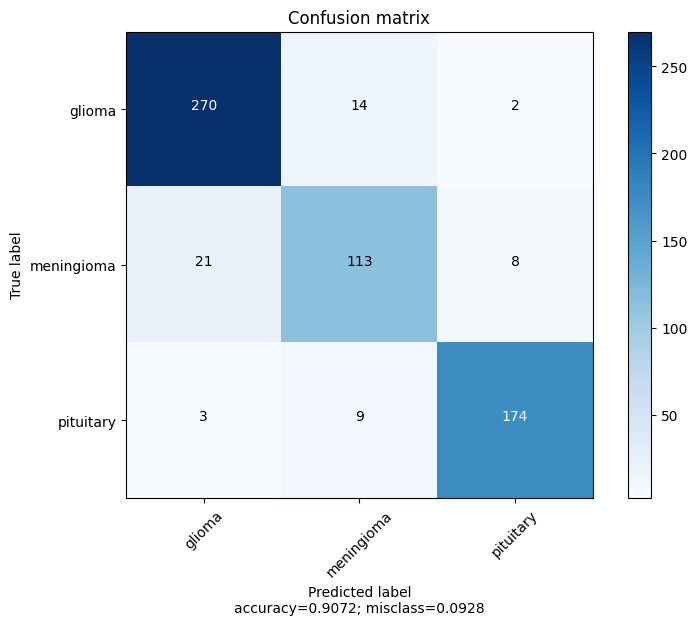

In [7]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-WMCFNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)